In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [69]:
# Choose the storage place for our data : CPU (host) or GPU (device) memory.
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
torch.manual_seed(0)
N = 10000  # Number of samples
t = torch.linspace(0, 2 * np.pi, N + 1)[:-1]
x = torch.stack((0.5 + 0.4 * (t / 7) * t.cos(), 0.5 + 0.3 * t.sin()), 1)
x = x + 0.02 * torch.randn(x.shape)
x = x.type(dtype)
x.requires_grad = True

# Create a uniform grid on the unit square:
res = 200
ticks = np.linspace(0, 1, res + 1)[:-1] + 0.5 / res
X, Y = np.meshgrid(ticks, ticks)

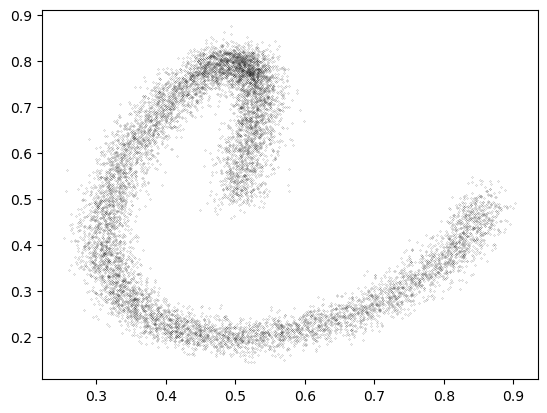

In [70]:
xy = x.data.cpu().numpy()
plt.scatter(xy[:, 0], xy[:, 1], 100 / len(xy), color="k")

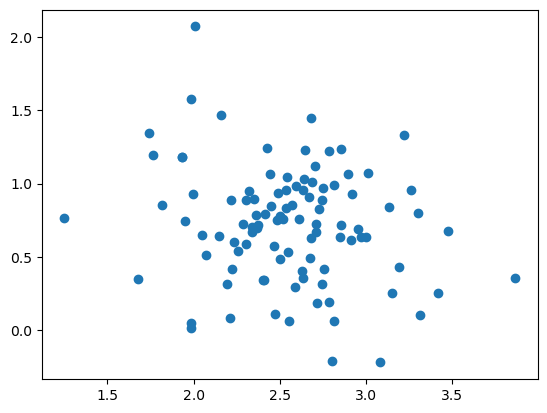

In [4]:
features, clusters = make_blobs(n_samples = 100,
                  n_features = 2, 
                  centers = 1,
                  cluster_std = 0.4,
                  shuffle = True)
plt.scatter(features[:,0], features[:,1])
plt.show()

In [5]:
features.shape

(100, 2)

In [6]:
class GaussianMixture(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = nn.Parameter(torch.rand(2))
        self.A = nn.Parameter(torch.rand((2, 2)))
    
    def forward(self, x):
        # shape x: (n_sample, 1, n_output)
        x = x.unsqueeze(0)
        sigma = torch.matmul(torch.tril(self.A), torch.tril(self.A).T)
        sigma.add_(torch.eye(2))
        latent_term = 1 / torch.sqrt(math.pow(2 * math.pi, 2) * torch.det(sigma))
        
        exp_term = torch.exp(-1/2 * (x - self.mu).T * torch.inverse(sigma).unsqueeze(1) * (x - self.mu))

        pdf = latent_term * exp_term
        pdf = pdf.logsumexp(dim=1)
        pdf = -torch.mean(pdf)
        
        # shape of the return tensor is (n_sample,)
        return pdf
    
class BIGaussianMixture(nn.Module):
    # we only pass the number of clusters,
    # we have a single correlation coefficient
    # so we are restricted to 2 coordinates only
    def __init__(self, n_clusters):
        super().__init__()
        
        # Parameters of the prior distribution
        # we will use an exponential parameterization of the categorical distribution
        # so no constraint on this :)
        self.prior = nn.Parameter(torch.zeros(n_clusters))
        
        self.mean = nn.Parameter(torch.empty((1, n_clusters, 2)).normal_())
        self.log_std = nn.Parameter(torch.empty((1, n_clusters, 2)).normal_())
        
        # The correlation coefficient
        # not that we learn a reparameterization that is unconstrained,
        # and the coef is self.reparemeterized_coef.tanh(),
        # so the value is between -1 and 1 as expected
        # (one limitation is that we can't have a coef=1 or =-1, but who cares?)
        self.reparameterized_coef = nn.Parameter(torch.empty((1, n_clusters)).normal_())
        
    # return log of the pdf (i.e. marginalize over the latent variable)
    # formula is avalable here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case
    # remember we are interested by the log PDF!
    def forward(self, x):
        # shape x: (n_sample, 1, n_output)
        x = x.unsqueeze(1)
        p = self.reparameterized_coef.tanh()
        # shape: (n_sample, n_latent, n_output)

        pdf = \
            - torch.log(2 * math.pi * self.log_std.exp().prod(2) * torch.sqrt(1 - p*p)) \
            - (1 / (2 * (1 - p * p))) * (
                ((x - self.mean).pow(2) / (self.log_std.exp().pow(2))).sum(2)
                - 2 * p * (x - self.mean).prod(2) / self.log_std.exp().prod(2)
            )
        
        pdf = pdf + self.prior.log_softmax(0).unsqueeze(0)
        pdf = pdf.logsumexp(dim=1)
        
        # shape of the return tensor is (n_sample,)
        return pdf

float64


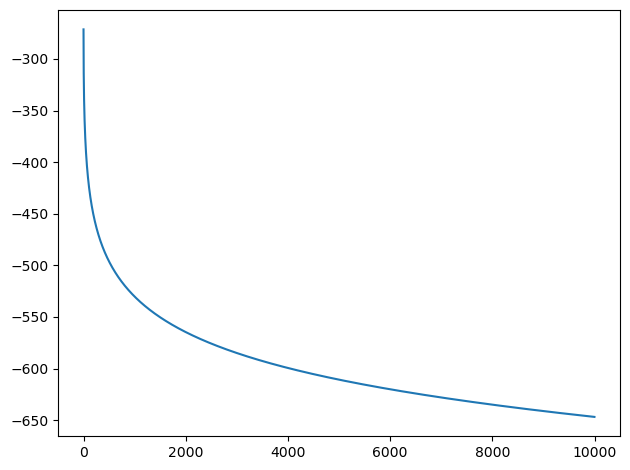

In [75]:
import torch
import torch.nn as nn

class MultivariateGaussian(nn.Module):
    def __init__(self):
        super(MultivariateGaussian, self).__init__()
        self.mean = nn.Parameter(torch.randn(2, dtype=torch.float64)) # random mean
        self.covar = nn.Parameter(torch.randn(2, 2, dtype=torch.float64)) # random covar matrix
        self.covar = nn.Parameter(self.covar @ self.covar.t() + torch.eye(2)) # make sure it is positive semidefinite
        self.chol_covar = torch.cholesky(self.covar)

    def forward(self, x):
        N, D = x.shape
        x_mu = x - self.mean
        self.chol_covar = torch.cholesky(self.covar)
        log_likelihood = -0.5 * (N * D * np.log(2 * np.pi) + N * 2. * torch.sum(torch.log(torch.diag(self.chol_covar))) + torch.sum((x_mu @ torch.inverse(self.chol_covar))**2, dim=-1))
        loss = torch.mean(log_likelihood)
        return loss


model = MultivariateGaussian()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

losses = np.zeros(10000)
print(features.dtype)
# During training
for i in range(10000):
    optimizer.zero_grad()
    loss = model(torch.from_numpy(features))
    loss.backward()
    optimizer.step()
    losses[i] = loss.data.cpu().numpy()

plt.figure()
plt.plot(losses)
plt.tight_layout()
plt.show()

In [76]:
model.mean

Parameter containing:
tensor([-22.0931,  -4.6571], dtype=torch.float64, requires_grad=True)

In [24]:
n_clusters = 3
g = GaussianMixture()
loss = np.zeros(100)

optimizer = torch.optim.Adam(g.parameters(), lr=0.1)

for it in range(100):
    optimizer.zero_grad()
    cost = g(torch.from_numpy(features)) / len(features)
    cost.backward()
    optimizer.step()
    loss[it] = cost.data.cpu().numpy()

In [25]:
gbi = BIGaussianMixture(2)
loss_bi = np.zeros(100)

optimizer = torch.optim.SGD(gbi.parameters(), lr=0.01, momentum=0.9)

for it in range(100):
    optimizer.zero_grad()
    cost = -torch.sum(gbi(torch.from_numpy(features))) / len(features)
    cost.backward()
    optimizer.step()
    loss_bi[it] = cost.data.cpu().numpy()

In [52]:
# Instantiate the module
mean = [0, 0]
cov = [[1, 0], [0, 1]]
gaussian = MultivariateGaussian(mean, cov)

# Define the optimizer
optimizer = torch.optim.Adam(gaussian.parameters())

# Define the loss function
loss_fn = nn.MSELoss()

# Define the data
x = torch.tensor(np.random.multivariate_normal(mean, cov, size=50), dtype=torch.float32)

# Optimize the parameters
for i in range(1000):
    optimizer.zero_grad()
    log_likelihood = gaussian(x)
    loss = -log_likelihood.mean()
    loss.backward()
    optimizer.step()

RuntimeError: Incompatible matrix sizes for cholesky_solve: each A matrix is 2 by 2 but each b matrix is 50 by 2

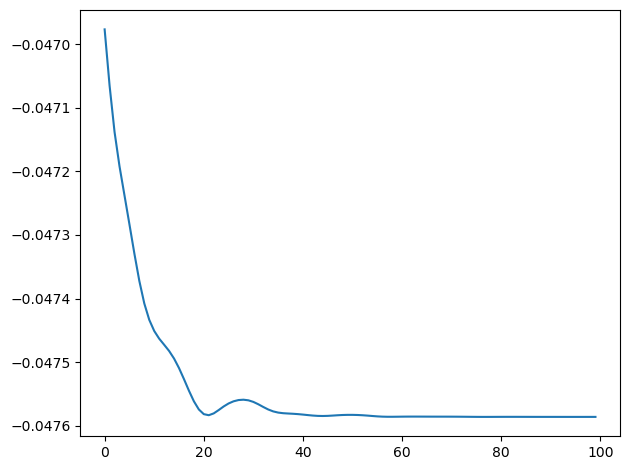

In [26]:
plt.figure()
plt.plot(loss)
plt.tight_layout()
plt.show()

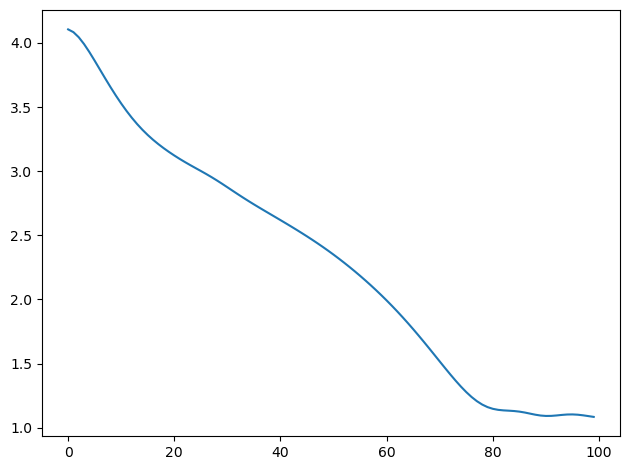

In [27]:
plt.figure()
plt.plot(loss_bi)
plt.tight_layout()
plt.show()

In [32]:
from scipy.stats import multivariate_normal

def plot_gaussian_contours(mean, cov, xy_points):
    x, y = np.linspace(1.5, 3.8, 500), np.linspace(0.4,1, 500)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    rv = multivariate_normal(mean, cov)
    plt.contour(X, Y, rv.pdf(pos))
    plt.scatter(xy_points[:, 0], xy_points[:, 1])
    plt.show()

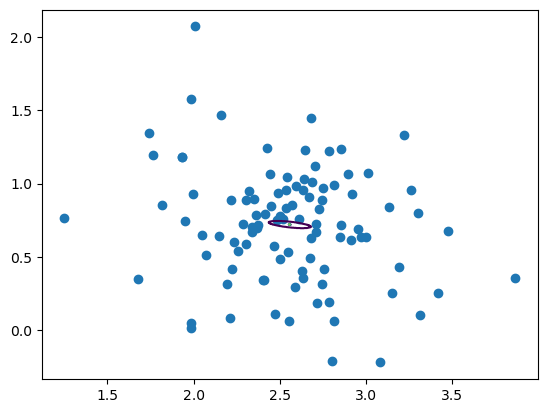

In [33]:
sigma_tmp = torch.matmul(torch.tril(g.A), torch.tril(g.A).T)
sigma_tmp = sigma_tmp.data.cpu().numpy()

plot_gaussian_contours(gbi.mu.data.cpu().numpy(), sigma_tmp, features)

In [379]:
def get_correlated_dataset(n, dependency, mu):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled_with_offset = dependent + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

In [176]:
def confidence_ellipse(sigma, mu, ax, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    pearson = sigma[0, 1]/np.sqrt(sigma[0, 0] * sigma[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(sigma[0, 0]) * 1
    mean_x = mu[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(sigma[1, 1]) * 1
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

TypeError: confidence_ellipse() got multiple values for argument 'facecolor'

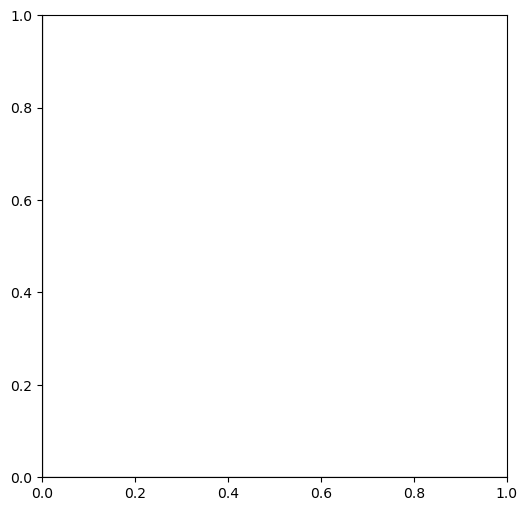

In [180]:
fig, ax_kwargs = plt.subplots(figsize=(6, 6))


ax_kwargs.axvline(c='grey', lw=1)
ax_kwargs.axhline(c='grey', lw=1)

x, y = get_correlated_dataset(500, torch.matmul(g.A, g.A.T).detach().numpy() / 2, g.mu.detach().numpy())
# Plot the ellipse with zorder=0 in order to demonstrate
# its transparency (caused by the use of alpha).
confidence_ellipse(torch.matmul(g.A, g.A.T).detach().numpy(), g.mu.detach().numpy(), ax_kwargs,
                   alpha=0.5, facecolor='pink', edgecolor='purple', zorder=0)

ax_kwargs.scatter(x, y, s=0.5)
ax_kwargs.scatter(g.mu.detach().numpy()[0], g.mu.detach().numpy()[1], c='red', s=3)
ax_kwargs.set_title('Using keyword arguments')

fig.subplots_adjust(hspace=0.25)
plt.show()